In [1]:
import numpy as np
import os
dtype = np.float32

import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import os

from transformers import CLIPVisionModelWithProjection, AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer, OPTForCausalLM, BloomForCausalLM,AutoModelForImageClassification
import numpy

from huggingface_hub import try_to_load_from_cache, _CACHED_NO_EXIST
from huggingface_hub import scan_cache_dir

import glob
import random
import json
import os

device = torch.device("cuda:0")
# device = torch.device("cpu")

def get_named_linears(module):
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def get_blocks(model):
    if model.__class__.__name__ in ("LlamaForCausalLM", "Qwen2ForCausalLM"):
        layers = model.model.layers
    elif model.__class__.__name__ == "LlavaLlamaForCausalLM":
        layers = model.model.layers
    elif isinstance(model, OPTForCausalLM):
        layers = model.model.decoder.layers
    elif isinstance(model, BloomForCausalLM):
        layers = model.transformer.h
    elif "mpt" in str(model.__class__).lower():
        layers = model.transformer.blocks
    elif "falcon" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "bigcode" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "neox" in str(model.__class__).lower():
        layers = model.gpt_neox.layers
    elif model.__class__.__name__ == "LlavaLlamaModel":
        layers = model.llm.model.layers
    elif model.__class__.__name__ in ("CLIPModel"):
        vision_layers = model.vision_model.encoder.layers
        text_layers = model.text_model.encoder.layers
        layers = {'vision': vision_layers,
                  'text': text_layers}
    elif model.__class__.__name__ in ("SiglipModel"):
        vision_layers = model.vision_model.encoder.layers
        text_layers = model.text_model.encoder.layers
        layers = {'vision': vision_layers,
                  'text': text_layers}
    elif model.__class__.__name__ == "Dinov2ForImageClassification":
        layers = model.dinov2.encoder.layer
    else:
        raise NotImplementedError(type(model))
    # if not isinstance(layers, dict):
    #     layers = {'': layers}
    return layers

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def flat_to_sym(V, N):
    A = torch.zeros(N, N, dtype=V.dtype, device=V.device)
    idxs = torch.tril_indices(N, N, device=V.device)
    A[idxs.unbind()] = V
    A[idxs[1, :], idxs[0, :]] = V
    return A

def regularize_H(H, n, sigma_reg):
    H.div_(torch.diag(H).mean())
    idx = torch.arange(n)
    H[idx, idx] += sigma_reg
    return H

import sys
sys.path.append('/workspace/Weight_compression/Wparam_dataset')
from utils import *

def RHT_H(H, SU):
    return matmul_hadUt(matmul_hadUt(H * SU).T * SU)

def RHT_W(W, SU, SV):
    return matmul_hadUt(matmul_hadUt(W.T * SV).T * SU)

def incoherence_preprocess(H, W, args):
    # dtype_ = torch.float64 if args.use_fp64 else torch.float32
    dtype_ = torch.float32
    device = H.device
    # device = torch.device('cpu')
    (m, n) = H.shape

    def _dump(Hr, Lhr, msg=''):
        torch.save(Hr, f"{args.save_pfx}/Hr_debug_fft.pt")
        torch.save(Lhr, f"{args.save_pfx}/Lhr_debug_fft.pt")
        raise Exception(msg)

    # diagonally rescale W,H to minimize proxy loss
    scaleWH = None
    Wr = W
    Hr = H
    # if args.rescale_WH:
    if False:
        Hr = H / H.abs().max()
        diagH = torch.diag(Hr)
        diagW2 = torch.diag(W.T @ W)
        diagH = torch.clamp(diagH, min=1e-8)
        diagW2 = torch.clamp(diagW2, min=1e-8)
        scaleWH = (diagH / diagW2).sqrt().sqrt().to(torch.float32)
        scaleWH = scaleWH.clamp(min=1e-8)
        Wr = Wr * scaleWH[None, :]
        Hr = Hr / scaleWH[None, :]
        Hr = Hr / scaleWH[:, None]
        scaleWH = scaleWH.cpu()

    # randomized hadamard transformation on H, W
    if True:
        SU = (torch.randn(n, device=device).sign() + 1e-5).sign().to(dtype_)
        SV = (torch.randn(m, device=device).sign() + 1e-5).sign().to(dtype_)
        Hr = RHT_H(Hr, SU)
        # Wr = RHT_W(Wr, SU, SV)
    # randomized kronecker product on H, W
    elif args.incoh_mode == "kron":
        SU = utils.rand_ortho_butterfly_noblock(n).to(dtype_).to(device)
        SV = utils.rand_ortho_butterfly_noblock(m).to(dtype_).to(device)
        Hr = SU @ Hr @ SU.T
        Wr = SV @ Wr @ SU.T
    else:
        raise NotImplementedError
    SV = SV.cpu()
    SU = SU.cpu()

    # Lhr = torch.linalg.cholesky(Hr)
    Lhr = None
    # if not torch.all(torch.isfinite(Lhr)):
    #     return None

    # Wr = Wr.to(device)

    return Lhr, Hr, Wr, SU, SV, scaleWH

### 전체 diagH의 분포

In [3]:
import matplotlib.pyplot as plt
model_list = [
    'meta-llama/Meta-Llama-3-8B',
    # 'meta-llama--Llama-2-7b-hf'
]
quip_hess_path = [
    './quip_hess/llama3_8b_6144',
    # './quip_hess/Hessians-Llama-2-7b-6144',
]
quip_hess_eig_path = [
    # './quip_hess_eig_reg0.0001/llama3_8b_6144',
    None
]

size_list = [
    1024,
    # 256,
    # 4096
]

wtype_mapping = {'self_attn.q_proj': 0, 
                 'self_attn.k_proj': 1, 
                 'self_attn.v_proj': 2, 
                 'self_attn.o_proj': 3, 
                 'mlp.gate_proj': 4, 
                 'mlp.up_proj': 5, 
                 'mlp.down_proj': 6}
sigma_reg = 1e-4
direction = 'col'
# direction = 'row'

global_std = 0.012529

for model_name, size, quip_hess, eig_path in zip(model_list, size_list, quip_hess_path, quip_hess_eig_path):
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)
    
    scaleH_list = []
        
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        
        hess_dict = {}
        hess_dict['qkv'] = torch.load(f'{quip_hess}/{i}_qkv.pt', weights_only=False)
        hess_dict['o'] = torch.load(f'{quip_hess}/{i}_o.pt', weights_only=False)
        hess_dict['up'] = torch.load(f'{quip_hess}/{i}_up.pt', weights_only=False)
        hess_dict['down'] = torch.load(f'{quip_hess}/{i}_down.pt', weights_only=False)
        
        # hess_eig_dict = {}
        # hess_eig_dict['qkv'] = torch.load(f'{eig_path}/{i}_qkv_eig.pt', weights_only=False)
        # hess_eig_dict['o'] = torch.load(f'{eig_path}/{i}_o_eig.pt', weights_only=False)
        # hess_eig_dict['up'] = torch.load(f'{eig_path}/{i}_up_eig.pt', weights_only=False)
        # hess_eig_dict['down'] = torch.load(f'{eig_path}/{i}_down_eig.pt', weights_only=False)
        
        for n, m in named_linears.items():
            
            W = m.weight.data.detach().to(device)
            
            if 'q_proj' in n or 'k_proj' in n or 'v_proj' in n:
                H_flat = hess_dict['qkv']
                # H_eig = hess_eig_dict['qkv']
            elif 'o_proj' in n:
                H_flat = hess_dict['o']
                # H_eig = hess_eig_dict['o']
            elif 'up_proj' in n or 'gate_proj' in n:
                H_flat = hess_dict['up']
                # H_eig = hess_eig_dict['up']
            elif 'down_proj' in n:
                H_flat = hess_dict['down']
                # H_eig = hess_eig_dict['down']
            else:
                raise NotImplementedError(n)
            
            H = flat_to_sym(H_flat['flatH'], H_flat['n']).to(device)
            mu = H_flat['mu'].to(device)
            H.add_(mu[None, :] * mu[:, None])
            n_h = H_flat['n']

            # print('before',torch.diag(H).mean())
            H = regularize_H(H, n_h, sigma_reg)
            # print('after',torch.diag(H).mean())
            
            diagH = torch.diag(H)
            diagH = torch.clamp(diagH, min=1e-8)
            scaleH = diagH.sqrt()
            
            scaleH_list.append(scaleH.flatten())

    
    

model_name:  meta-llama--Meta-Llama-3-8B


100%|██████████| 32/32 [00:55<00:00,  1.73s/it]


I1106 18:53:35.008098 2149584 utils.py:148] Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
I1106 18:53:35.009248 2149584 utils.py:151] Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
I1106 18:53:35.009648 2149584 utils.py:164] NumExpr defaulting to 16 threads.


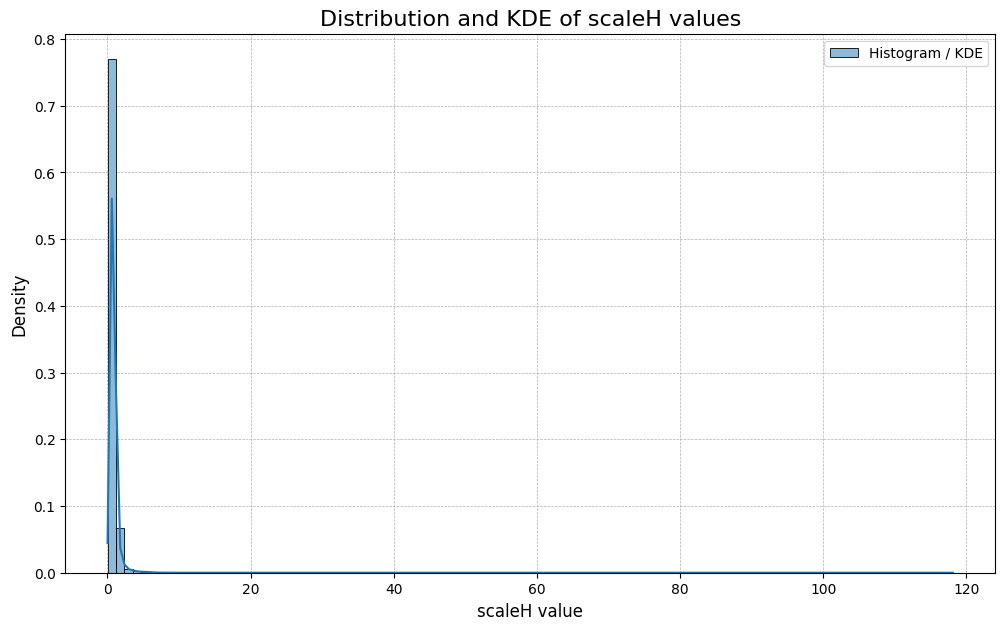

In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


if isinstance(scaleH_list, list):
    # 리스트에 담긴 여러 텐서를 하나로 합칩니다.
    scaleH_list = torch.cat(scaleH_list)

# .cpu()를 호출하여 GPU에 있을 수 있는 텐서를 CPU로 옮깁니다.
# .numpy()로 NumPy 배열로 변환한 후 .flatten()으로 1차원으로 만듭니다.
scaleH_flat_numpy = scaleH_list.cpu().numpy().flatten()

# 플롯 사이즈 설정
plt.figure(figsize=(12, 7))

# seaborn을 사용하여 히스토그램과 KDE를 함께 플로팅합니다.
# stat="density" 옵션은 히스토그램의 y축을 빈도수가 아닌 밀도로 정규화하여
# KDE 플롯과 스케일을 맞춥니다.
sns.histplot(scaleH_flat_numpy, bins=100, kde=True, stat="density", label='Histogram / KDE')

# 플롯 제목 및 라벨 설정
plt.title('Distribution and KDE of scaleH values', fontsize=16)
plt.xlabel('scaleH value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# 플롯을 이미지 파일로 저장
# plt.savefig('scaleH_distribution_plot.png')ß

# (선택 사항) 플롯을 화면에 표시
plt.show()

# print("플롯이 'scaleH_distribution_plot.png' 파일로 저장되었습니다.")


In [ ]:
print("Shape:", scaleH_flat_numpy.shape)
print("Mean:", scaleH_flat_numpy.mean())
print("Min:", scaleH_flat_numpy.min())
print("Max:", scaleH_flat_numpy.max())


In [ ]:
import numpy as np
import torch

# --- 데이터 준비 (시뮬레이션) ---
scaleH_flat_numpy = scaleH_list.cpu().numpy().flatten()
# ---------------------------------


# 1. 원하는 비율을 정의 (작은 비율부터)
target_percentages = np.array([0.1, 1, 10, 88.9])
# 값이 작은 데이터부터 차지할 비율을 순서대로 정렬합니다.
percentages_for_boundaries = np.sort(target_percentages)[::-1] # [88.9, 10. ,  1. ,  0.1]

# 2. 경계가 될 누적 백분위수 계산
# [88.9, 98.9, 99.9]
cumulative_percentiles = np.cumsum(percentages_for_boundaries)[:-1]

print("--- 목표 비율 및 계산된 백분위수 지점 (역순 적용) ---")
print(f"값이 작은 순서대로 차지할 목표 비율: {percentages_for_boundaries}")
print(f"경계를 찾을 누적 백분위수: {cumulative_percentiles}")
print("-" * 50)


# 3. np.percentile을 사용하여 실제 경계 값 찾기
boundaries = np.percentile(scaleH_flat_numpy, cumulative_percentiles)

# 전체 경계 리스트 (min, 경계1, 경계2, 경계3, max)
full_boundaries = np.concatenate(([scaleH_flat_numpy.min()], boundaries, [scaleH_flat_numpy.max()]))

print("\n--- 계산된 구간 경계 값 ---")
print(f"최소값: {full_boundaries[0]:.6f}")
print(f"경계 1 (하위 88.9% 지점): {full_boundaries[1]:.6f}")
print(f"경계 2 (하위 98.9% 지점): {full_boundaries[2]:.6f}")
print(f"경계 3 (하위 99.9% 지점): {full_boundaries[3]:.6f}")
print(f"최대값: {full_boundaries[4]:.6f}")
print("-" * 50)


# 4. (검증) 위에서 찾은 경계로 데이터를 나누고 실제 비율 확인
digitized_indices = np.digitize(scaleH_flat_numpy, bins=boundaries)

total_data_count = len(scaleH_flat_numpy)
bin_counts = np.bincount(digitized_indices, minlength=len(target_percentages))


# 5. 검증 결과 출력 (평균과 중간값 추가)
print("\n--- [검증] 구간별 상세 정보 (비율, 평균, 중간값) ---")
value_groups = ["가장 작은 값 그룹", "중간 값 그룹 1", "중간 값 그룹 2", "가장 큰 값 그룹"]
for i in range(len(target_percentages)):
    lower_bound = full_boundaries[i]
    upper_bound = full_boundaries[i+1]
    count = bin_counts[i]
    
    # 이 구간에 해당하는 데이터만 선택하기 위한 마스크 생성
    mask = (digitized_indices == i)
    
    if count > 0:
        # 마스크를 사용해 현재 구간의 데이터만 추출
        data_in_bin = scaleH_flat_numpy[mask]
        
        # 평균과 중간값 계산
        mean_val = data_in_bin.mean()
        median_val = np.median(data_in_bin)
    else:
        # 데이터가 없는 경우 (일반적이지 않음)
        mean_val = np.nan
        median_val = np.nan
        
    actual_percentage = (count / total_data_count) * 100
    
    print(f"구간 {i+1} ({value_groups[i]}, 목표: {percentages_for_boundaries[i]:.1f}%):")
    print(f"  - 범위        : {lower_bound:.6f} ~ {upper_bound:.6f}")
    print(f"  - 실제 비율   : {actual_percentage:.4f} % (총 {count}개)")
    print(f"  - 평균 (Mean)   : {mean_val:.6f}")
    print(f"  - 중간값 (Median): {median_val:.6f}")
    print("-" * 45)

In [ ]:
import numpy as np
import torch

# 이전 코드에서 scaleH_flat_numpy 변수가 생성되었다고 가정합니다.
# (없다면 아래 주석 처리된 라인으로 생성)
# scaleH_list = torch.cat(scaleH_list)
# scaleH_flat_numpy = scaleH_list.cpu().numpy().flatten()

# 1. 백분위수를 사용하여 4개 구간의 경계 찾기
boundaries = np.percentile(scaleH_flat_numpy, [0, 25, 50, 75, 100])

print("백분위수 기반 구간 경계:")
print(f" min ( 0%): {boundaries[0]:.6f}")
print(f"25%: {boundaries[1]:.6f}")
print(f"50% (Median): {boundaries[2]:.6f}")
print(f"75%: {boundaries[3]:.6f}")
print(f" max (100%): {boundaries[4]:.6f}")

# 2. 각 값을 4개의 레벨(0, 1, 2, 3)으로 양자화(quantize)하기
# np.digitize는 각 값이 어느 구간에 속하는지 인덱스를 반환해줍니다.
quantized_values = np.digitize(scaleH_flat_numpy, bins=boundaries[1:-1])

print("\n예시:")
print(f"원본 값 상위 5개: {scaleH_flat_numpy[:5]}")
print(f"양자화된 값 상위 5개: {quantized_values[:5]}")

# 3. (선택) 대표값을 각 구간의 평균값으로 설정할 수도 있습니다.
representative_values = []
for i in range(4):
    # i 레벨에 해당하는 값들의 마스크 생성
    mask = (quantized_values == i)
    if np.any(mask):
        # 마스크에 해당하는 값들의 평균 계산
        mean_val = scaleH_flat_numpy[mask].mean()
        # mean_val = scaleH_flat_numpy[mask].max()
        representative_values.append(mean_val)
    else:
        # 해당 구간에 데이터가 없는 경우 (일반적이지 않음)
        representative_values.append(np.nan)

print("\n각 레벨(0,1,2,3)의 대표값 (평균):")
for i, val in enumerate(representative_values):
    print(f"Level {i}: {val:.6f}")

In [ ]:
import numpy as np
import torch

# 이전 코드에서 scaleH_flat_numpy 변수가 생성되었다고 가정합니다.
# (없다면 아래 주석 처리된 라인으로 생성)
# scaleH_list = torch.cat(scaleH_list)
# scaleH_flat_numpy = scaleH_list.cpu().numpy().flatten()

# 1. 25, 50, 75 백분위수 계산
percentiles = np.percentile(scaleH_flat_numpy, [25, 50, 75])

# 2. 대표값 리스트 생성 (마지막 값은 100으로 고정)
representative_values_A = [percentiles[0], percentiles[1], percentiles[2], 100.0]

print("--- 방법 1: 백분위수 값을 그대로 사용 ---")
print(f"25% 지점 값: {representative_values_A[0]:.6f}")
print(f"50% 지점 값: {representative_values_A[1]:.6f}")
print(f"75% 지점 값: {representative_values_A[2]:.6f}")
print(f"사용자 지정 최대값: {representative_values_A[3]}")
print("\n최종 대표값 리스트:", representative_values_A)

In [ ]:
import numpy as np
import torch

# --- 데이터 준비 (시뮬레이션) ---
# 사용자의 실제 'scaleH_flat_numpy' 데이터를 사용해야 합니다.
# 아래 코드는 실행 가능한 예시를 위해 비슷한 분포를 시뮬레이션하는 부분입니다.
# 실제 데이터는 대부분 0에 가깝고 긴 꼬리를 가지므로, log-normal 분포로 유사하게 생성합니다.
np.random.seed(42)
simulated_data = np.random.lognormal(mean=-2, sigma=1.5, size=1000000)
# 사용자는 아래 라인 대신 실제 데이터를 사용해야 합니다.
scaleH_flat_numpy = scaleH_list.cpu().numpy().flatten()
# scaleH_flat_numpy = simulated_data
# ---------------------------------


# 1. 데이터의 범위를 균일하게 4개로 나누는 경계 생성
num_bins = 4
min_val = scaleH_flat_numpy.min()
max_val = scaleH_flat_numpy.max()

# np.linspace를 사용하여 최소값과 최대값 사이를 4개의 구간(5개의 경계점)으로 나눕니다.
uniform_boundaries = np.linspace(min_val, max_val, num_bins + 1)

print("--- 균일하게 나눈 구간 경계 ---")
for i, b in enumerate(uniform_boundaries):
    print(f"경계 {i}: {b:.6f}")
print("-" * 30)


# 2. np.digitize를 사용하여 각 데이터가 어느 구간에 속하는지 확인
# bins 인자에는 양 끝 경계를 제외한 [경계1, 경계2, 경계3]을 넣어줍니다.
# 결과: 값 < 경계1 -> 0, 경계1 <= 값 < 경계2 -> 1, ... , 값 >= 경계3 -> 3
digitized_indices = np.digitize(scaleH_flat_numpy, bins=uniform_boundaries[1:-1])


# 3. 각 구간별 데이터 수 및 비율 계산
total_data_count = len(scaleH_flat_numpy)
# np.bincount는 각 인덱스(0, 1, 2, 3)의 개수를 세어줍니다.
bin_counts = np.bincount(digitized_indices, minlength=num_bins)


# 4. 결과 출력
print("\n--- 구간별 데이터 분포 비율 ---")
for i in range(num_bins):
    lower_bound = uniform_boundaries[i]
    upper_bound = uniform_boundaries[i+1]
    count = bin_counts[i]
    percentage = (count / total_data_count) * 100
    
    print(f"구간 {i+1} (범위: {lower_bound:.4f} ~ {upper_bound:.4f}):")
    print(f"  - 데이터 수: {count}")
    print(f"  - 비율: {percentage:.4f} %")
    print("-" * 20)

# H별 플롯

In [ ]:
import matplotlib.pyplot as plt
model_list = [
    'meta-llama/Meta-Llama-3-8B',
    'meta-llama--Llama-2-7b-hf'
]
quip_hess_path = [
    './quip_hess/llama3_8b_6144',
    './quip_hess/Hessians-Llama-2-7b-6144',
]
quip_hess_eig_path = [
    # './quip_hess_eig_reg0.0001/llama3_8b_6144',
    None
]
sigma_reg = 1e-4

for model_name, quip_hess, eig_path in zip(model_list,quip_hess_path, quip_hess_eig_path):
    
    SAVE_DIR = os.path.join('./plots', quip_hess.split('/')[-1])
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)
            
    for i in tqdm(range(len(layers))):
        named_linears = get_named_linears(layers[i])
        
        hess_dict = {}
        hess_dict['qkv'] = torch.load(f'{quip_hess}/{i}_qkv.pt', weights_only=False)
        hess_dict['o'] = torch.load(f'{quip_hess}/{i}_o.pt', weights_only=False)
        hess_dict['up'] = torch.load(f'{quip_hess}/{i}_up.pt', weights_only=False)
        hess_dict['down'] = torch.load(f'{quip_hess}/{i}_down.pt', weights_only=False)
        
        for k, v in hess_dict.items():
            H_flat = v
            H = flat_to_sym(H_flat['flatH'], H_flat['n']).to(device)
            mu = H_flat['mu'].to(device)
            H.add_(mu[None, :] * mu[:, None])
            n_h = H_flat['n']

            # print('before',torch.diag(H).mean())
            H = regularize_H(H, n_h, sigma_reg)
            # print('after',torch.diag(H).mean())
            
            diagH = torch.diag(H)
            diagH = torch.clamp(diagH, min=1e-8)
            # scaleH = diagH.sqrt()
            scaleH = diagH
            
            
            L = torch.linalg.cholesky(H)
            H_inv = torch.cholesky_inverse(L)
            diag_Hinv = torch.diag(H_inv)
            diag_Hinv_repo = 1.0 / diag_Hinv
            diag_Hinv_repo = torch.clamp(diag_Hinv_repo, min=1e-8)
            # scaleH2 = diag_Hinv_repo.sqrt()
            scaleH2 = diag_Hinv_repo
            
            scaleH_sorted = torch.sort(scaleH).values.cpu().numpy()
            scaleH2_sorted = torch.sort(scaleH2).values.cpu().numpy()
            
            # ################################################
            scaleH_mean = scaleH.mean().item()
            scaleH_min = scaleH.min().item()
            scaleH_max = scaleH.max().item()
            
            scaleH2_mean = scaleH2.mean().item()
            scaleH2_min = scaleH2.min().item()
            scaleH2_max = scaleH2.max().item()
            
            # 통계치를 표시할 텍스트 생성 (과학적 표기법 .4e 사용)
            stats_text_1 = (
                f"Mean: {scaleH_mean}\n"
                f"Min:  {scaleH_min}\n"
                f"Max:  {scaleH_max}"
            )
            stats_text_2 = (
                f"Mean: {scaleH2_mean}\n"
                f"Min:  {scaleH2_min}\n"
                f"Max:  {scaleH2_max}"
            )
            # ################################################
            
            
            fig, axes = plt.subplots(2, 1, figsize=(8, 10))
            axes[0].plot(scaleH_sorted, label='sqrt diag(H) sorted', linewidth=2, color='blue')
            axes[0].set_xlabel("Index (sorted)")
            axes[0].set_ylabel("Value")
            axes[0].set_title(f"Layer {i}_{k}: Sorted sqrt(diag(H))")
            axes[0].legend()
            axes[0].grid(True, linestyle='--', alpha=0.5)
            # 플롯의 좌상단에 통계 텍스트 추가
            axes[0].text(0.05, 0.95, stats_text_1, 
                         transform=axes[0].transAxes, 
                         fontsize=10, verticalalignment='top', 
                         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

            axes[1].plot(scaleH2_sorted, label='sqrt 1/diag(H⁻¹) sorted', linewidth=2, color='red') # label 수정
            axes[1].set_xlabel("Index (sorted)")
            axes[1].set_ylabel("Value")
            # 제목에서 'sqrt' 제거 (코드와 일치)
            axes[1].set_title(f"Layer {i}_{k}: Sorted sqrt(1/diag(H⁻¹))")
            axes[1].legend()
            axes[1].grid(True, linestyle='--', alpha=0.5)
            # 플롯의 좌상단에 통계 텍스트 추가
            axes[1].text(0.05, 0.95, stats_text_2, 
                         transform=axes[1].transAxes, 
                         fontsize=10, verticalalignment='top', 
                         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

            out_path = os.path.join(SAVE_DIR, f"{i}_{k}.png")
            os.makedirs(os.path.dirname(out_path), exist_ok = True)
            
            plt.tight_layout() # Subplot 간 간격 자동 조절
            plt.savefig(out_path, dpi=300)
            plt.close(fig) # fig 객체를 명시적으로 닫음
            print(f"✅ Saved (subplot): {out_path}")
    
    

In [ ]:
import matplotlib.pyplot as plt
import os
import torch
from tqdm import tqdm

model_list = [
    'meta-llama/Meta-Llama-3-8B',
    'meta-llama--Llama-2-7b-hf'
]
quip_hess_path = [
    './quip_hess/llama3_8b_6144',
    './quip_hess/Hessians-Llama-2-7b-6144',
]
quip_hess_eig_path = [
    # './quip_hess_eig_reg0.0001/llama3_8b_6144',
    None,
    None # Added to match length of model_list
]
sigma_reg = 1e-4

for model_name, quip_hess, eig_path in zip(model_list, quip_hess_path, quip_hess_eig_path):
    
    SAVE_DIR = os.path.join('./plots', quip_hess.split('/')[-1])
    
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    
    model_path = f"./hf_model/{model_name}"

    # model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    # layers = get_blocks(model)
    
    # --- Using dummy layers/linears for demonstration ---
    # Replace this with your actual model loading logic
    print("Warning: Using dummy model loading and layer processing")
    layers = [None] * 2 # Dummy for 2 layers
    dummy_named_linears = {'qkv': None, 'o': None, 'up': None, 'down': None}
    # --- End of dummy section ---
            
    for i in tqdm(range(len(layers))):
        # named_linears = get_named_linears(layers[i]) # Your original code
        named_linears = dummy_named_linears # Using dummy
        
        hess_dict = {}
        try:
            hess_dict['qkv'] = torch.load(f'{quip_hess}/{i}_qkv.pt', weights_only=False)
            hess_dict['o'] = torch.load(f'{quip_hess}/{i}_o.pt', weights_only=False)
            hess_dict['up'] = torch.load(f'{quip_hess}/{i}_up.pt', weights_only=False)
            hess_dict['down'] = torch.load(f'{quip_hess}/{i}_down.pt', weights_only=False)
        except Exception as e:
            print(f"Error loading files for layer {i}, model {model_name}: {e}")
            print("Skipping this layer.")
            continue
            
        for k, v in hess_dict.items():
            if v is None:
                print(f"Skipping {k} as loaded data is None.")
                continue
                
            H_flat = v
            n_h = H_flat['n']
            if n_h == 0:
                print(f"Skipping {k} as n_h is 0.")
                continue
                
            H = flat_to_sym(H_flat['flatH'], H_flat['n']).to(device)
            mu = H_flat['mu'].to(device)
            H.add_(mu[None, :] * mu[:, None])

            # print('before',torch.diag(H).mean())
            H = regularize_H(H, n_h, sigma_reg)
            # print('after',torch.diag(H).mean())
            
            diagH = torch.diag(H)
            diagH = torch.clamp(diagH, min=1e-8)
            
            # --- Values WITHOUT sqrt ---
            scaleH = diagH
            
            try:
                L = torch.linalg.cholesky(H)
                H_inv = torch.cholesky_inverse(L)
            except torch.linalg.LinAlgError as e:
                print(f"Cholesky decomposition failed for {i}_{k}: {e}")
                print("Skipping this plot.")
                continue
                
            diag_Hinv = torch.diag(H_inv)
            diag_Hinv_repo = 1.0 / diag_Hinv
            diag_Hinv_repo = torch.clamp(diag_Hinv_repo, min=1e-8)
            
            # --- Values WITHOUT sqrt ---
            scaleH2 = diag_Hinv_repo
            
            # --- Values WITH sqrt ---
            scaleH_sqrt = diagH.sqrt()
            scaleH2_sqrt = diag_Hinv_repo.sqrt()
            
            # --- Sort all versions ---
            scaleH_sorted = torch.sort(scaleH).values.cpu().numpy()
            scaleH2_sorted = torch.sort(scaleH2).values.cpu().numpy()
            scaleH_sqrt_sorted = torch.sort(scaleH_sqrt).values.cpu().numpy()
            scaleH2_sqrt_sorted = torch.sort(scaleH2_sqrt).values.cpu().numpy()
            
            # ################################################
            # --- Stats for WITHOUT sqrt ---
            scaleH_mean = scaleH.mean().item()
            scaleH_min = scaleH.min().item()
            scaleH_max = scaleH.max().item()
            
            scaleH2_mean = scaleH2.mean().item()
            scaleH2_min = scaleH2.min().item()
            scaleH2_max = scaleH2.max().item()
            
            # --- Stats for WITH sqrt ---
            scaleH_sqrt_mean = scaleH_sqrt.mean().item()
            scaleH_sqrt_min = scaleH_sqrt.min().item()
            scaleH_sqrt_max = scaleH_sqrt.max().item()
            
            scaleH2_sqrt_mean = scaleH2_sqrt.mean().item()
            scaleH2_sqrt_min = scaleH2_sqrt.min().item()
            scaleH2_sqrt_max = scaleH2_sqrt.max().item()

            # --- Stat text for WITHOUT sqrt ---
            stats_text_1 = (
                f"Mean: {scaleH_mean: .4e}\n"
                f"Min:  {scaleH_min: .4e}\n"
                f"Max:  {scaleH_max: .4e}"
            )
            stats_text_2 = (
                f"Mean: {scaleH2_mean: .4e}\n"
                f"Min:  {scaleH2_min: .4e}\n"
                f"Max:  {scaleH2_max: .4e}"
            )
            
            # --- Stat text for WITH sqrt ---
            stats_text_3 = (
                f"Mean: {scaleH_sqrt_mean: .4e}\n"
                f"Min:  {scaleH_sqrt_min: .4e}\n"
                f"Max:  {scaleH_sqrt_max: .4e}"
            )
            stats_text_4 = (
                f"Mean: {scaleH2_sqrt_mean: .4e}\n"
                f"Min:  {scaleH2_sqrt_min: .4e}\n"
                f"Max:  {scaleH2_sqrt_max: .4e}"
            )
            # ################################################
            
            
            # --- Create 2x2 subplot grid ---
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle(f'Model: {model_name.split("--")[-1]} - Layer {i} - Component {k}', fontsize=16)

            # --- Plot 1: diag(H) (NO sqrt) ---
            axes[0, 0].plot(scaleH_sorted, label='diag(H) sorted', linewidth=2, color='blue')
            axes[0, 0].set_xlabel("Index (sorted)")
            axes[0, 0].set_ylabel("Value")
            axes[0, 0].set_title(f"Sorted diag(H)")
            axes[0, 0].legend()
            axes[0, 0].grid(True, linestyle='--', alpha=0.5)
            axes[0, 0].text(0.05, 0.95, stats_text_1, 
                            transform=axes[0, 0].transAxes, 
                            fontsize=10, verticalalignment='top', 
                            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

            # --- Plot 2: 1/diag(H⁻¹) (NO sqrt) ---
            axes[0, 1].plot(scaleH2_sorted, label='1/diag(H⁻¹) sorted', linewidth=2, color='red')
            axes[0, 1].set_xlabel("Index (sorted)")
            axes[0, 1].set_ylabel("Value")
            axes[0, 1].set_title(f"Sorted 1/diag(H⁻¹)")
            axes[0, 1].legend()
            axes[0, 1].grid(True, linestyle='--', alpha=0.5)
            axes[0, 1].text(0.05, 0.95, stats_text_2, 
                            transform=axes[0, 1].transAxes, 
                            fontsize=10, verticalalignment='top', 
                            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

            # --- Plot 3: sqrt(diag(H)) (WITH sqrt) ---
            axes[1, 0].plot(scaleH_sqrt_sorted, label='sqrt diag(H) sorted', linewidth=2, color='green')
            axes[1, 0].set_xlabel("Index (sorted)")
            axes[1, 0].set_ylabel("Value")
            axes[1, 0].set_title(f"Sorted sqrt(diag(H))")
            axes[1, 0].legend()
            axes[1, 0].grid(True, linestyle='--', alpha=0.5)
            axes[1, 0].text(0.05, 0.95, stats_text_3, 
                            transform=axes[1, 0].transAxes, 
                            fontsize=10, verticalalignment='top', 
                            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

            # --- Plot 4: sqrt(1/diag(H⁻¹)) (WITH sqrt) ---
            axes[1, 1].plot(scaleH2_sqrt_sorted, label='sqrt 1/diag(H⁻¹) sorted', linewidth=2, color='purple')
            axes[1, 1].set_xlabel("Index (sorted)")
            axes[1, 1].set_ylabel("Value")
            axes[1, 1].set_title(f"Sorted sqrt(1/diag(H⁻¹))")
            axes[1, 1].legend()
            axes[1, 1].grid(True, linestyle='--', alpha=0.5)
            axes[1, 1].text(0.05, 0.95, stats_text_4, 
                            transform=axes[1, 1].transAxes, 
                            fontsize=10, verticalalignment='top', 
                            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

            out_path = os.path.join(SAVE_DIR, f"{i}_{k}.png")
            os.makedirs(os.path.dirname(out_path), exist_ok = True)
            
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
            plt.savefig(out_path, dpi=300)
            plt.close(fig) # fig 객체를 명시적으로 닫음
            print(f"✅ Saved (4 subplots): {out_path}")

# --- Restore original torch.load if mocked ---
# In your real environment, remove this line.
torch.load = _original_torch_load
# --- End of restore ---

print("Done processing all models.")